In [1]:
import pandas as pd
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType, TimestampType, BinaryType
import pyspark.sql.functions as F
from pyspark.sql.functions import count, when, col
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style='darkgrid')
plt.figure(figsize=(22, 20))

<Figure size 2200x2000 with 0 Axes>

<Figure size 2200x2000 with 0 Axes>

# Exploratory Data Analysis and Data Preparation

In [2]:
spark = SparkSession.builder.appName("UNSW_data").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/13 21:11:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/13 21:11:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
sc = spark.sparkContext

In [4]:
# Load the features data
features_df = spark.read.csv("./UNSW-NB15_features.csv", header=True, inferSchema=True)

# Load the attack events data
attacks_df = spark.read.csv("./UNSW-NB15_LIST_EVENTS.csv", header=True, inferSchema=True)

In [5]:
features_df.show(10)

+---+------+-------+--------------------+
|No.|  Name|  Type |         Description|
+---+------+-------+--------------------+
|  1| srcip|nominal|   Source IP address|
|  2| sport|integer|  Source port number|
|  3| dstip|nominal|Destination IP ad...|
|  4|dsport|integer|Destination port ...|
|  5| proto|nominal|Transaction protocol|
|  6| state|nominal|Indicates to the ...|
|  7|   dur|  Float|Record total dura...|
|  8|sbytes|Integer|Source to destina...|
|  9|dbytes|Integer|Destination to so...|
| 10|  sttl|Integer|Source to destina...|
+---+------+-------+--------------------+
only showing top 10 rows



In [6]:
attacks_df.show(10)

+---------------+------------------+----------------+
|Attack category|Attack subcategory|Number of events|
+---------------+------------------+----------------+
|         normal|              NULL|         2218761|
|       Fuzzers |               FTP|             558|
|       Fuzzers |              HTTP|            1497|
|       Fuzzers |               RIP|            3550|
|       Fuzzers |               SMB|            5245|
|       Fuzzers |            Syslog|            1851|
|       Fuzzers |              PPTP|            1583|
|        Fuzzers|               FTP|             248|
|        Fuzzers|            DCERPC|             164|
|        Fuzzers|              OSPF|             993|
+---------------+------------------+----------------+
only showing top 10 rows



The attacks_df the Attack category shows that the normal is denoted as NULL, meaning we will have to replace the NULL values with normal

In [7]:
print(features_df.columns)

['No.', 'Name', 'Type ', 'Description']


We need to rename the Type column of the features_df in order to access it as it denoted as "Type " instead of "Type", so we can easily access it for data processing.

In [8]:
features_df = features_df.withColumnRenamed('Type ', 'Type')

In [9]:
def get_spark_type(typ):
    if typ == 'nominal':
        return StringType()
    elif typ == 'integer':
        return IntegerType()
    elif typ == 'float':
        return FloatType()
    elif typ == 'timestamp':
        return TimestampType()
    elif typ == 'binary':
        return IntegerType()
    else:
        raise ValueError(f"Unsupported type: {typ}")

In [10]:
# Extract the column names and data types from the features DataFrame
feature_names = [row.Name for row in features_df.collect()]
feature_types = [row.Type.lower()for row in features_df.collect()]

In [11]:
feature_names

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'service',
 'Sload',
 'Dload',
 'Spkts',
 'Dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'Sjit',
 'Djit',
 'Stime',
 'Ltime',
 'Sintpkt',
 'Dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'attack_cat',
 'Label']

In [12]:
feature_types

['nominal',
 'integer',
 'nominal',
 'integer',
 'nominal',
 'nominal',
 'float',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'nominal',
 'float',
 'float',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'float',
 'float',
 'timestamp',
 'timestamp',
 'float',
 'float',
 'float',
 'float',
 'float',
 'binary',
 'integer',
 'integer',
 'binary',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'integer',
 'nominal',
 'binary']

In [13]:
print([(name, typ) for name, typ in zip(feature_names, feature_types)])

[('srcip', 'nominal'), ('sport', 'integer'), ('dstip', 'nominal'), ('dsport', 'integer'), ('proto', 'nominal'), ('state', 'nominal'), ('dur', 'float'), ('sbytes', 'integer'), ('dbytes', 'integer'), ('sttl', 'integer'), ('dttl', 'integer'), ('sloss', 'integer'), ('dloss', 'integer'), ('service', 'nominal'), ('Sload', 'float'), ('Dload', 'float'), ('Spkts', 'integer'), ('Dpkts', 'integer'), ('swin', 'integer'), ('dwin', 'integer'), ('stcpb', 'integer'), ('dtcpb', 'integer'), ('smeansz', 'integer'), ('dmeansz', 'integer'), ('trans_depth', 'integer'), ('res_bdy_len', 'integer'), ('Sjit', 'float'), ('Djit', 'float'), ('Stime', 'timestamp'), ('Ltime', 'timestamp'), ('Sintpkt', 'float'), ('Dintpkt', 'float'), ('tcprtt', 'float'), ('synack', 'float'), ('ackdat', 'float'), ('is_sm_ips_ports', 'binary'), ('ct_state_ttl', 'integer'), ('ct_flw_http_mthd', 'integer'), ('is_ftp_login', 'binary'), ('ct_ftp_cmd', 'integer'), ('ct_srv_src', 'integer'), ('ct_srv_dst', 'integer'), ('ct_dst_ltm', 'integer

In [14]:
# Create a list of StructField objects based on the feature names and types
fields = [StructField(name, get_spark_type(typ), True) for name, typ in zip(feature_names, feature_types)]

# Create a StructType object from the list of StructField objects
schema = StructType(fields)

In [15]:
schema

StructType([StructField('srcip', StringType(), True), StructField('sport', IntegerType(), True), StructField('dstip', StringType(), True), StructField('dsport', IntegerType(), True), StructField('proto', StringType(), True), StructField('state', StringType(), True), StructField('dur', FloatType(), True), StructField('sbytes', IntegerType(), True), StructField('dbytes', IntegerType(), True), StructField('sttl', IntegerType(), True), StructField('dttl', IntegerType(), True), StructField('sloss', IntegerType(), True), StructField('dloss', IntegerType(), True), StructField('service', StringType(), True), StructField('Sload', FloatType(), True), StructField('Dload', FloatType(), True), StructField('Spkts', IntegerType(), True), StructField('Dpkts', IntegerType(), True), StructField('swin', IntegerType(), True), StructField('dwin', IntegerType(), True), StructField('stcpb', IntegerType(), True), StructField('dtcpb', IntegerType(), True), StructField('smeansz', IntegerType(), True), StructFie

In [16]:
df = spark.read.csv("./UNSW-NB15.csv", schema=schema)

In [17]:
df.show()

24/05/13 21:11:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+-----+-----+---------+---------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss| service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|Stime|Ltime|  Sintpkt|  Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+-----+--------+------

In [18]:
df.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: float (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- Sload: float (nullable = true)
 |-- Dload: float (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-

* `srcip`: This column contains the source IP address of the network connection.
* `sport`: This column contains the source port number used in the network connection.
* `dstip`: This column contains the destination IP address of the network connection.
* `dsport`: This column contains the destination port number used in the network connection.
* `proto`: This column contains the protocol used in the network connection (e.g., TCP, UDP, ICMP).
* `state`: This column contains the state of the network connection (e.g., open, closed, filtered).
* `dur`: This column contains the duration of the network connection in seconds.
* `sbytes`: This column contains the number of bytes sent from the source IP address during the network connection.
* `dbytes`: This column contains the number of bytes sent from the destination IP address during the network connection.
* `sttl`: This column contains the source IP address Time to Live (TTL) value, which is the maximum number of hops that a packet can travel before being discarded.
* `dttl`: This column contains the destination IP address TTL value.
* `sloss`: This column contains the number of packets sent from the source IP address that were lost during the network connection.
* `dloss`: This column contains the number of packets sent from the destination IP address that were lost during the network connection.
* `service`: This column contains the name of the service or application associated with the destination port number.
* `Sload`: This column contains the source load, which is the number of connections initiated by the source IP address in the last second.
* `Dload`: This column contains the destination load, which is the number of connections initiated to the destination IP address in the last second.
* `Spkts`: This column contains the number of packets sent from the source IP address during the network connection.
* `Dpkts`: This column contains the number of packets sent from the destination IP address during the network connection.
* `swin`: This column contains the source window size, which is the number of bytes that the source IP address is willing to accept in a single packet.
* `dwin`: This column contains the destination window size.
* `stcpb`: This column contains the source TCP base sequence number, which is the initial sequence number used by the source IP address in the network connection.
* `dtcpb`: This column contains the destination TCP base sequence number.
* `smeansz`: This column contains the mean segment size sent from the source IP address during the network connection.
* `dmeansz`: This column contains the mean segment size sent from the destination IP address during the network connection.
* `trans_depth`: This column contains the number of times a packet was retransmitted during the network connection.
* `res_bdy_len`: This column contains the length of the response body in bytes.
* `Sjit`: This column contains the source jitter, which is the variation in the inter-arrival times of packets sent from the source IP address.
* `Djit`: This column contains the destination jitter.
* `Sintpkt`: This column contains the source inter-packet arrival time, which is the time interval between the arrival of two consecutive packets sent from the source IP address.
* `Dintpkt`: This column contains the destination inter-packet arrival time.
* `tcprtt`: This column contains the round-trip time for a TCP packet, which is the time it takes for a packet to travel from the source IP address to the destination IP address and back.
* `synack`: This column contains the number of SYN-ACK packets sent during the network connection.
* `ackdat`: This column contains the number of ACK packets sent with data during the network connection.
* `is_sm_ips_ports`: This column contains a flag indicating whether the source and destination IP addresses and ports are in the same subnet.
* `ct_state_ttl`: This column contains the connection state TTL, which is the time-to-live value for the connection state.
* `ct_flw_http_mthd`: This column contains the HTTP method used in the network connection (e.g., GET, POST).
* `is_ftp_login`: This column contains a flag indicating whether the network connection is an FTP login attempt.
* `ct_ftp_cmd`: This column contains the FTP command used in the network connection.
* `ct_srv_src`: This column contains the source IP address of the server in the network connection.
* `ct_srv_dst`: This column contains the destination IP address of the server in the network connection.
* `ct_dst_ltm`: This column contains the last time the destination IP address was seen in the network traffic.
* `ct_src_ltm`: This column contains the last time the source IP address was seen in the network traffic.
* `ct_src_dport_ltm`: This column contains the last time the source port number was seen in the network traffic.
* `ct_dst_sport_ltm`: This column contains the last time the destination port number was seen in the network traffic.
* `ct_dst_src_ltm`: This column contains the last time the destination and source IP addresses were seen together in the network traffic.
* `attack_cat`: This column contains the attack category for the network connection (e.g., DoS, R2L, U2R, Probe).
* `Label`: This column contains the label for the network connection (0 for normal and 1 for attack).

In [19]:
df.count()

2539739

In [20]:
spark2 = SparkSession.builder \
    .appName("Hive Data Analysis") \
    .enableHiveSupport() \
    .getOrCreate()

24/05/13 21:11:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [21]:
# Create a Hive table
df.createOrReplaceTempView("df_hive_table")

In [22]:
def display_analysis(data, column_name):
    data = data.sort_values(by='count', ascending=False)

    plt.figure(figsize=(25, 6))
    plt.bar(data[column_name], data['count'], color='skyblue')
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Count')
    plt.title(f'Count of {column_name.capitalize()}')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()

In [23]:
#Distribution of Protocols used in Network Connections:
query1 = """
    SELECT proto, COUNT(*) AS count
    FROM df_hive_table
    GROUP BY proto
    ORDER BY count DESC;
"""

result_df = spark2.sql(query1)

result_pd = result_df.toPandas()

In [24]:
result_pd

,proto,count
0,tcp,1495074
1,udp,990435
2,unas,16202
3,arp,10064
4,ospf,7798
...,...,...
129,xns-idp,137
130,encap,137
131,igmp,64
132,udt,8


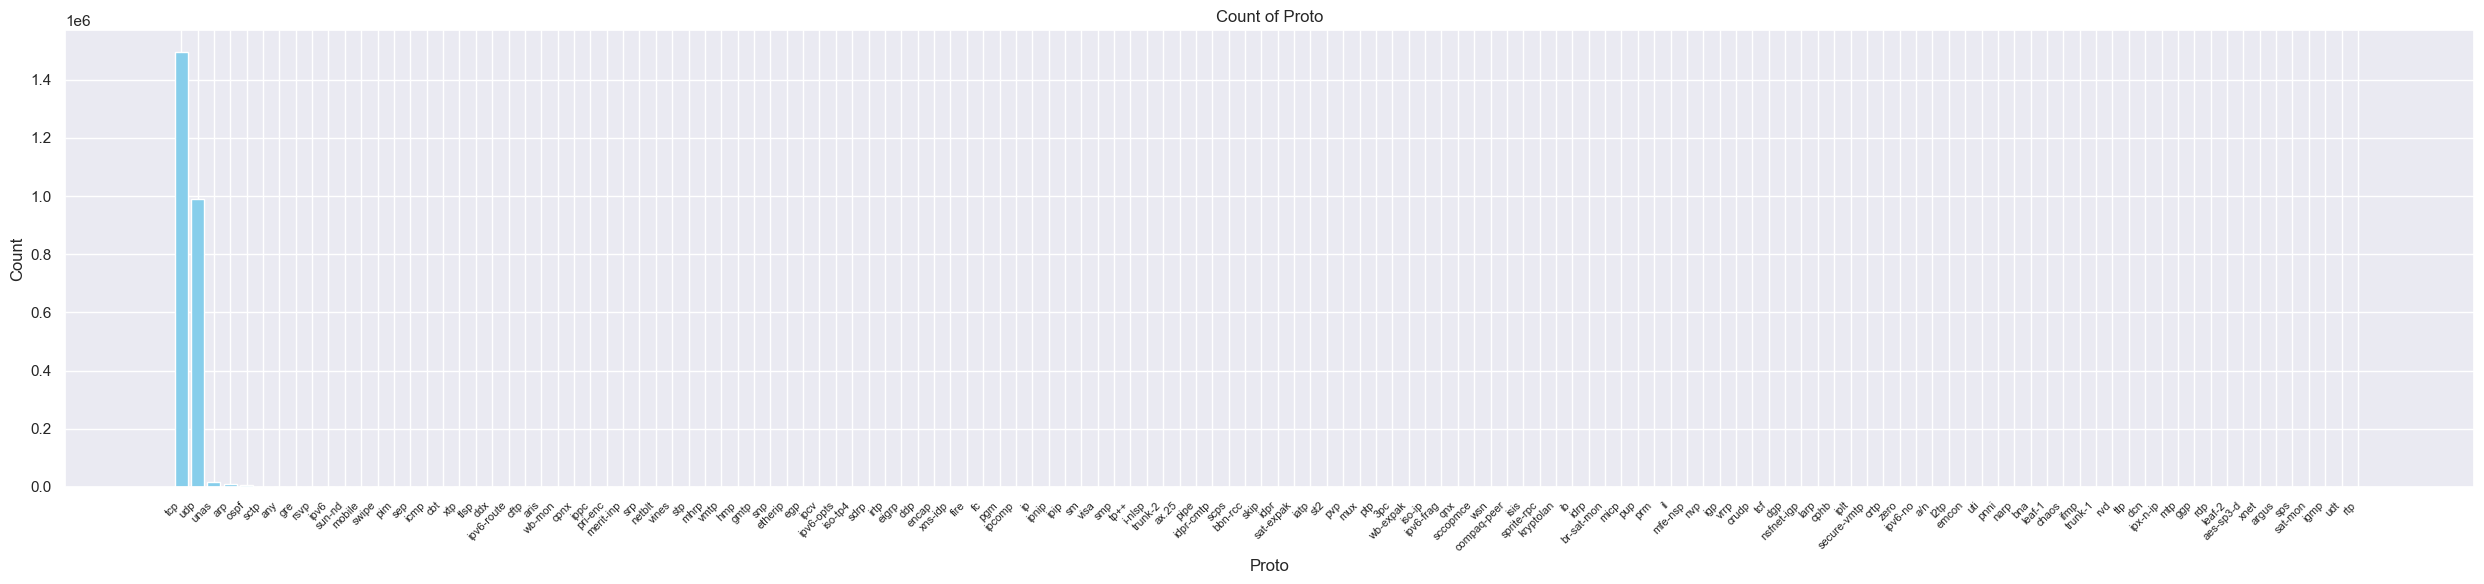

In [25]:
display_analysis(result_pd, 'proto')

In [26]:
#Top 10 Attack Categories:
query1 = """
    SELECT attack_cat, COUNT(*) AS count
    FROM df_hive_table
    WHERE Label = 1
    GROUP BY attack_cat
    ORDER BY count DESC
    LIMIT 10;
"""

result_df = spark2.sql(query1)

result_pd = result_df.toPandas()

24/05/13 21:11:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [27]:
result_pd

,attack_cat,count
0,Generic,215481
1,Exploits,44525
2,Fuzzers,19195
3,DoS,16353
4,Reconnaissance,12228
5,Fuzzers,5051
6,Analysis,2677
7,Backdoor,1795
8,Reconnaissance,1759
9,Shellcode,1288


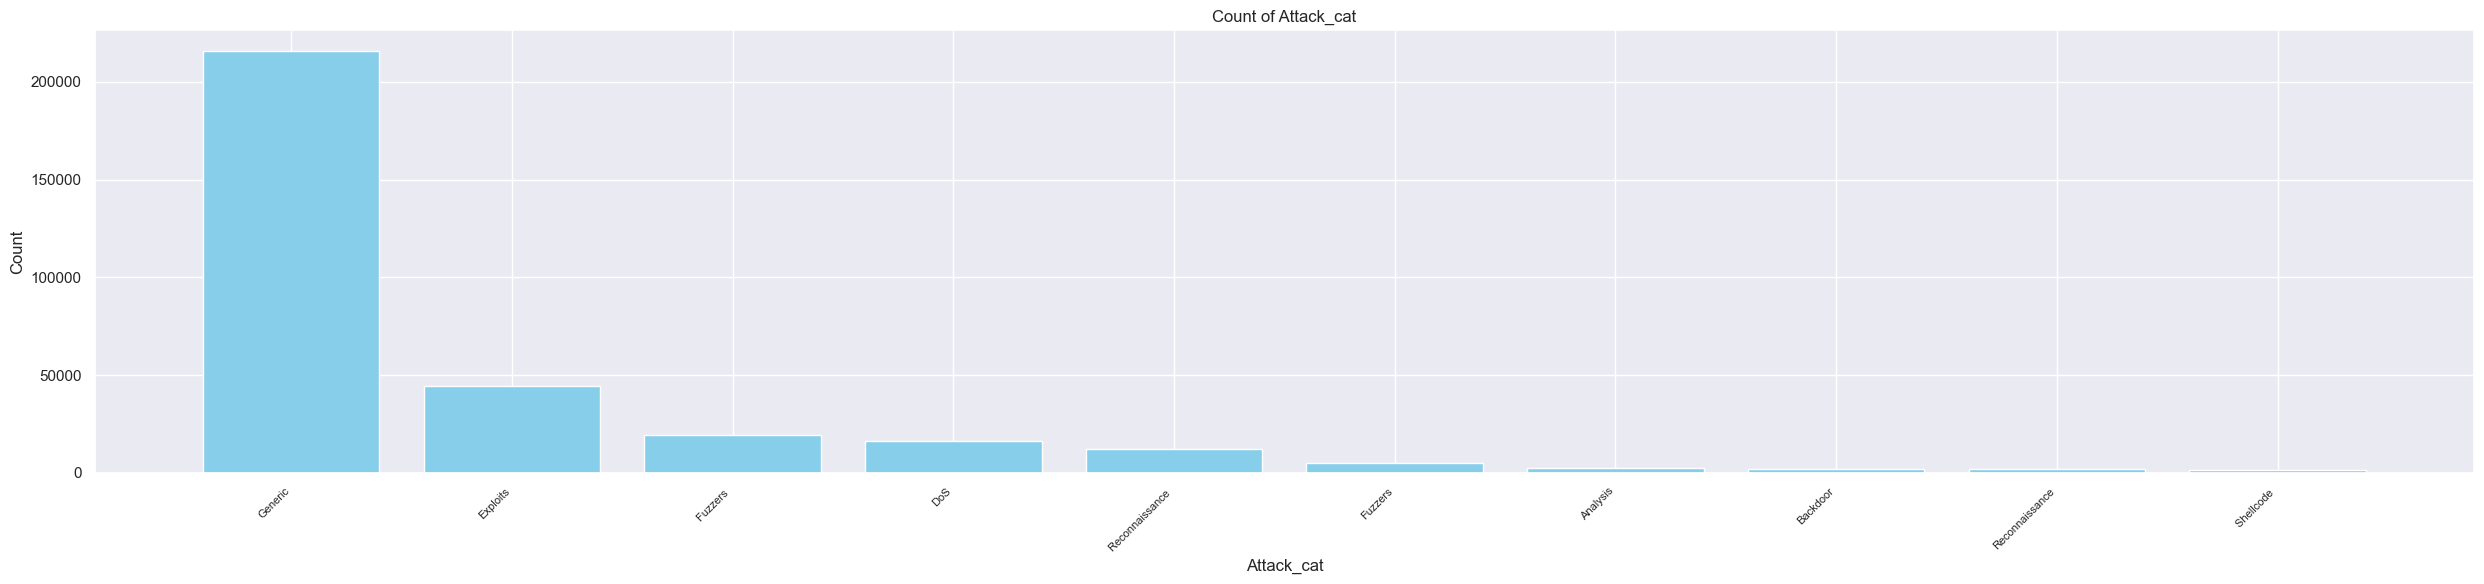

In [28]:
display_analysis(result_pd, 'attack_cat')

In [29]:
#Average Source Bytes Sent per Attack Category:
query1 = """
    SELECT attack_cat, AVG(sbytes) AS avg_sbytes
    FROM df_hive_table
    WHERE Label = 1
    GROUP BY attack_cat;
"""

result_df = spark2.sql(query1)

result_pd = result_df.toPandas()

In [30]:
result_pd

,attack_cat,avg_sbytes
0,Worms,2255.775862
1,Analysis,839.645125
2,Shellcode,533.074534
3,DoS,18360.793799
4,Reconnaissance,784.400147
5,Backdoor,1803.989415
6,Fuzzers,7032.913884
7,Exploits,29655.004065
8,Generic,356.961983
9,Shellcode,531.452915


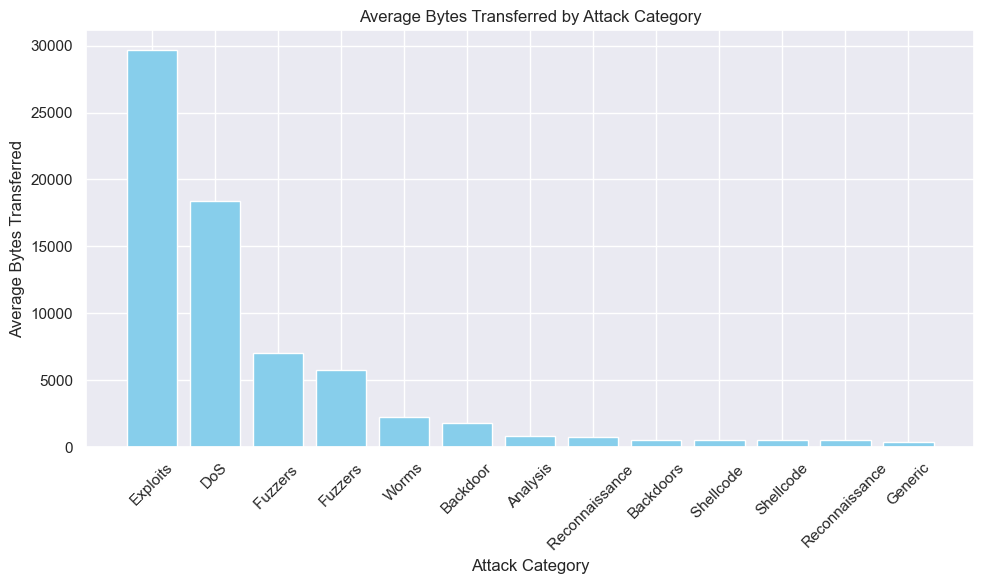

In [31]:
# Grouping the result_pd by attack category and taking the mean of avg_sbytes
avg_bytes_by_attack = result_pd.groupby('attack_cat')['avg_sbytes'].mean().reset_index()
avg_bytes_by_attack = avg_bytes_by_attack.sort_values(by='avg_sbytes', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(avg_bytes_by_attack['attack_cat'], avg_bytes_by_attack['avg_sbytes'], color='skyblue')
plt.xlabel('Attack Category')
plt.ylabel('Average Bytes Transferred')
plt.title('Average Bytes Transferred by Attack Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
#TCP Round-Trip Time Distribution:
query1 = """
    SELECT tcprtt
    FROM df_hive_table
    WHERE proto = 'tcp'
    AND tcprtt IS NOT NULL;
"""

result_df = spark2.sql(query1)

result_pd = result_df.toPandas()

In [33]:
result_pd

,tcprtt
0,0.000597
1,0.000680
2,0.001250
3,0.000684
4,0.000619
...,...
1495069,0.000669
1495070,0.000671
1495071,0.000839
1495072,0.000822


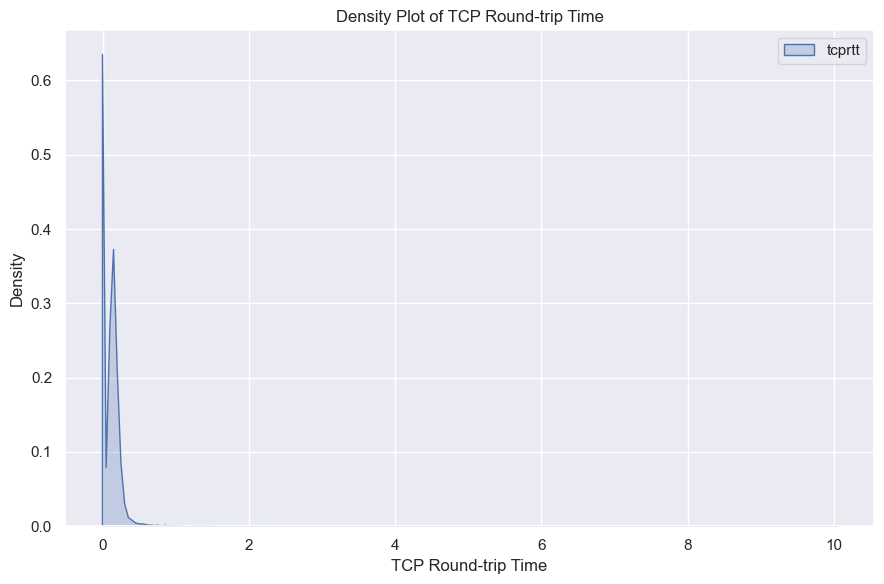

In [34]:
plt.figure(figsize=(9, 6))
sns.kdeplot(result_pd, fill=True, color='skyblue')
plt.xlabel('TCP Round-trip Time')
plt.ylabel('Density')
plt.title('Density Plot of TCP Round-trip Time')
plt.tight_layout()
plt.show()

In [35]:
# del spark2

# Check for Missing values

In [36]:
def check_missing_values(dataframe):
    total_rows = dataframe.count()

    missing_values = dataframe.select([count(when(col(c).isNull(), c)).alias(c) for c in dataframe.columns])
    missing_percentage = missing_values.select([(col(c) / total_rows * 100).alias(c) for c in dataframe.columns])
    
    missing_values.show()
    missing_percentage.show()

In [37]:
check_missing_values(df)

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+------+------+-------+-------+-----------+-----------+----+----+-------+-------+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|Sload|Dload|Spkts|Dpkts|swin|dwin| stcpb| dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|  Stime|  Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+------+------+-------+-------+-----------+

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+------------------+------------------+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+-----------------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|Sload|Dload|Spkts|Dpkts|swin|dwin|             stcpb|             dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Stime|Ltime|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|       attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+----

From the analysis above, low missing values in the stcpb, dtcpb which will be replaced with zero(0), Stime 100%, Ltime 100%, and attack_cat 87% has the highest number of missing values
I will drop the Stime and Ltime columns, so to prevent removing the entire entries, and replace the attack_cat missing values with normal as the attack_cat is critical for the multiclassification model development.

In [38]:
df = df.drop('Stime', 'Ltime')

In [39]:
from pyspark.sql.functions import col, replace, lower, trim

df_clean = df.fillna('normal', subset=['attack_cat'])
# Convert the "attack_cat" column to lowercase and remove leading/trailing spaces
df_clean = df_clean.withColumn("attack_cat", lower(trim(col("attack_cat"))))

df_clean.select("attack_cat").distinct().show()

+--------------+
|    attack_cat|
+--------------+
|       generic|
|     shellcode|
|        normal|
|         worms|
|reconnaissance|
|      analysis|
|       fuzzers|
|           dos|
|      backdoor|
|      exploits|
|     backdoors|
+--------------+



In [40]:
# df_clean = df_clean.dropna(subset=[c for c in df_clean.columns], how='any')
df_clean = df_clean.fillna(0, subset=[c for c in df_clean.columns])

In [41]:
check_missing_values(df_clean)

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-------+-------+

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-------+-------+

In [42]:
df_clean.show(5)

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+---------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|  Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+

# Categorical columns:
`proto`, `service`, `state`
# Numerical but binary: 
`is_sm_ips_ports`, `is_ftp_login`

In [43]:
print([col.name for col in df_clean.schema if isinstance(col.dataType, StringType)])

['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat']


In [44]:
df_clean.select("srcip").distinct().show()

+--------------+
|         srcip|
+--------------+
|149.171.126.16|
|    59.166.0.5|
|   10.40.170.2|
|    59.166.0.8|
|    10.40.85.1|
|149.171.126.18|
|    59.166.0.3|
| 149.171.126.7|
|  175.45.176.1|
|149.171.126.15|
|   10.40.85.10|
| 149.171.126.4|
|    59.166.0.6|
|    59.166.0.4|
|149.171.126.17|
| 149.171.126.2|
|149.171.126.13|
|149.171.126.10|
|    59.166.0.1|
| 149.171.126.3|
+--------------+
only showing top 20 rows



In [45]:
df_clean.select("dstip").distinct().show()

+--------------+
|         dstip|
+--------------+
|149.171.126.16|
|    59.166.0.5|
|   10.40.170.2|
|    59.166.0.8|
|    10.40.85.1|
|     224.0.0.5|
|149.171.126.18|
| 149.171.126.7|
|    59.166.0.3|
|  175.45.176.1|
|149.171.126.15|
| 149.171.126.4|
|    59.166.0.6|
|    59.166.0.4|
|149.171.126.17|
| 149.171.126.2|
|  10.40.198.10|
|149.171.126.13|
|149.171.126.10|
|    59.166.0.1|
+--------------+
only showing top 20 rows



In [46]:
df_clean.select("proto").distinct().show()

+----------+
|     proto|
+----------+
|      cphb|
|      larp|
|nsfnet-igp|
|       dgp|
|       tcf|
|     crudp|
|      vrrp|
|       igp|
|       nvp|
|   mfe-nsp|
|        il|
|       prm|
|      micp|
|  wb-expak|
|      ospf|
|br-sat-mon|
|      idrp|
|        ib|
| kryptolan|
|sprite-rpc|
+----------+
only showing top 20 rows



In [47]:
df_clean.select("state").distinct().show()

+-----+
|state|
+-----+
|  URN|
|  ACC|
|  ECO|
|  ECR|
|  PAR|
|  RST|
|  REQ|
|  FIN|
|  INT|
|  MAS|
|   no|
|  CON|
|  TST|
|  TXD|
|  URH|
|  CLO|
+-----+



In [48]:
df_clean.select("service").distinct().show()

+--------+
| service|
+--------+
|     ftp|
|ftp-data|
|     dns|
|    smtp|
|    http|
|  radius|
|     ssl|
|       -|
|     irc|
|    dhcp|
|    snmp|
|    pop3|
|     ssh|
+--------+



We will replace the “-“ with “Others”

In [49]:
df_clean = df_clean.withColumn("service", when(df_clean["service"] == "-", "Others").otherwise(df_clean["service"]))

In [50]:
df_clean.select("service").distinct().show()

+--------+
| service|
+--------+
|     ftp|
|ftp-data|
|     dns|
|    smtp|
|    http|
|  radius|
|     ssl|
|  Others|
|     irc|
|    dhcp|
|    snmp|
|    pop3|
|     ssh|
+--------+



In [51]:
df_clean.select("is_sm_ips_ports").distinct().show()

+---------------+
|is_sm_ips_ports|
+---------------+
|              1|
|              0|
+---------------+



In [52]:
df_clean.select("is_ftp_login").distinct().show()

+------------+
|is_ftp_login|
+------------+
|           1|
|           4|
|           2|
|           0|
+------------+



In this dataset I found that even though `is_ftp_login` is a binary column it has values other than 0 and 1. Let’s remove all except 0 and 1.

In [53]:
df_clean = df_clean.filter(col("is_ftp_login").isin([0, 1]))
df_clean.select("is_ftp_login").distinct().show()

+------------+
|is_ftp_login|
+------------+
|           1|
|           0|
+------------+



In [54]:
df_clean.select("attack_cat").distinct().show()

+--------------+
|    attack_cat|
+--------------+
|       generic|
|     shellcode|
|        normal|
|         worms|
|reconnaissance|
|      analysis|
|       fuzzers|
|           dos|
|      backdoor|
|      exploits|
|     backdoors|
+--------------+



And in attack category we have same category twice the difference is singular and plural.

In [55]:
print("Number of data for 'backdoor':", df_clean.filter(lower(trim(col("attack_cat"))) == "backdoor").count())
print("Number of data for 'backdoors':", df_clean.filter(lower(trim(col("attack_cat"))) == "backdoors").count())

Number of data for 'backdoor': 1795


Number of data for 'backdoors': 534


In [56]:
# Replace "backdoors" with "backdoor"
df_clean = df_clean.withColumn("attack_cat", 
                        when(df_clean["attack_cat"] == "backdoors", "backdoor")
                        .otherwise(df_clean["attack_cat"]))

In [57]:
df_clean.select("attack_cat").distinct().show()

+--------------+
|    attack_cat|
+--------------+
|       generic|
|     shellcode|
|        normal|
|         worms|
|reconnaissance|
|      analysis|
|       fuzzers|
|           dos|
|      backdoor|
|      exploits|
+--------------+



# Target Columns
We are performing two different classifications as this is a Supervised Machine Learning Task, Binary and Multi-class classification.
* Binary Classification we will make use of the Label as the target for development,
* Multi-class Classification we will use the attack_cat as the target for development.

In [58]:
import numpy as np

def display_target_distribution(dataframe, column_name: str):
    # Filter out null values
    dataframe = dataframe.filter(dataframe[column_name].isNotNull())

    cats_and_counts = dataframe.groupBy(column_name).count().orderBy('count', ascending=False).collect()
    cats = [row[column_name] for row in cats_and_counts]
    counts = [row['count'] for row in cats_and_counts]
    
    # Generate evenly spaced x positions for the bars
    x_pos = np.arange(len(cats))

    plt.bar(x_pos, counts)
    plt.xlabel(f'{column_name.split("_")[0].capitalize()} Category')
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name.split("_")[0].capitalize()} Categories')

    plt.xticks(x_pos, cats, rotation=45, ha='right')
    plt.tight_layout()
    plt.figure(figsize=(22, 20))

    plt.show()


In [59]:
df_clean.select('attack_cat').distinct().show()

+--------------+
|    attack_cat|
+--------------+
|       generic|
|     shellcode|
|        normal|
|         worms|
|reconnaissance|
|      analysis|
|       fuzzers|
|           dos|
|      backdoor|
|      exploits|
+--------------+



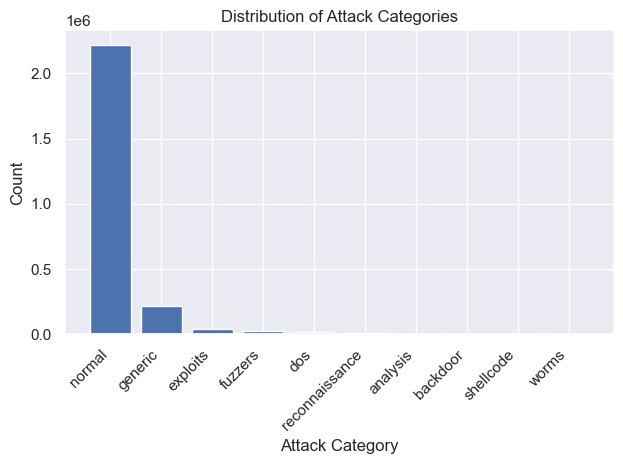

<Figure size 2200x2000 with 0 Axes>

In [60]:
display_target_distribution(df_clean, 'attack_cat')

The attack_cat column is heavily imbalanced, this categories will introduce bias during model prediction.

The data is highly imbalanced and have lots of non-attack than attacks.
In train data most occurred attack data categories are “Generic”, “Exploits”, Fuzzers”, “DoS” and “Reconnaissance”, "analysis", "backdoor", "shellcode", "worms"

In [61]:
df_clean.select('Label').distinct().show()

+-----+
|Label|
+-----+
|    1|
|    0|
+-----+



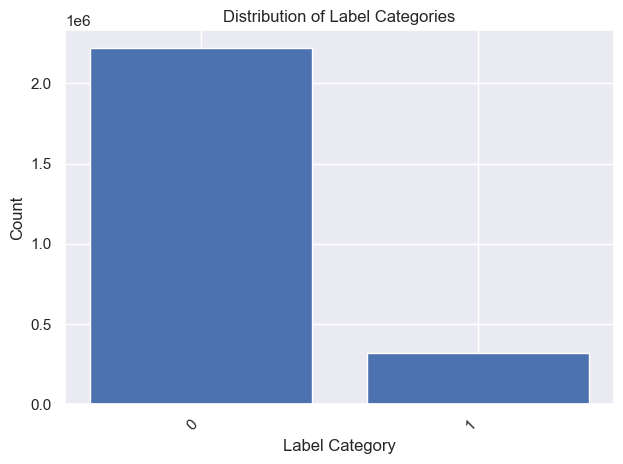

<Figure size 2200x2000 with 0 Axes>

In [62]:
display_target_distribution(df_clean, 'Label')

The Label is imbalanced, this categories will also introduce bias during model prediction.

In [63]:
from typing import List

def col_countplot(column, data, occurences_of_interest: List[str]):
    """
    This function plots countplot of a given feature for dataset
    """
    
    # Filter the DataFrame based on the occurrences of interest
    filtered_df = df_clean.filter(col(column).isin(occurences_of_interest))

    # Convert PySpark DataFrame to Pandas DataFrame
    pandas_df = filtered_df.select(column, 'Label').toPandas()
    
    fig, ax = plt.subplots(figsize=(12, 6))  # Increase the size of the plot
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=column, hue='Label', data=pandas_df)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("Data")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels further
    plt.tight_layout()  # Adjust layout for better readability
    plt.show()

In [64]:
def check_cat_occurence(col_name):
    # Count occurrences of each category in a categorical column
    df_clean.groupBy(col_name).count().orderBy('count', ascending=False).show()

# Proto

In [65]:
check_cat_occurence('proto')

+----------+-------+
|     proto|  count|
+----------+-------+
|       tcp|1494888|
|       udp| 990435|
|      unas|  16202|
|       arp|  10064|
|      ospf|   7798|
|      sctp|   1525|
|       any|    411|
|       gre|    324|
|      rsvp|    274|
|      ipv6|    272|
|    sun-nd|    262|
|    mobile|    262|
|     swipe|    262|
|       pim|    262|
|       sep|    260|
|      icmp|    218|
|      cphb|    137|
|      larp|    137|
|nsfnet-igp|    137|
|       dgp|    137|
+----------+-------+
only showing top 20 rows



They are alot of occurence of those categories we will focus on the most occurences for analysis, we will focus on the 'tcp', 'udp', 'unas', 'arp', 'ospf'

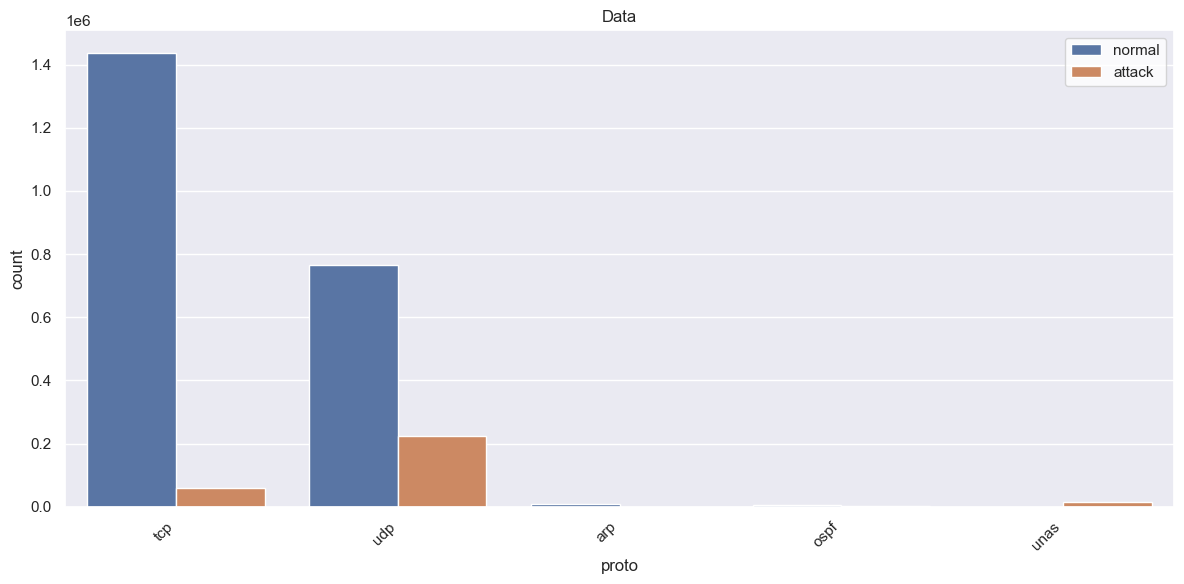

In [66]:
col_countplot('proto', df_clean, ['tcp', 'udp', 'unas', 'arp', 'ospf'])

Most of the values are consists of udp and tcp.
For normal data, count of tcp is lot higher.
Considering the imbalance there are lots of udp category for attacks.

# Service

In [67]:
check_cat_occurence('service')

+--------+-------+
| service|  count|
+--------+-------+
|  Others|1246086|
|     dns| 781668|
|    http| 206273|
|ftp-data| 125783|
|    smtp|  81645|
|     ftp|  48907|
|     ssh|  47160|
|    pop3|   1533|
|    dhcp|    172|
|     ssl|    142|
|    snmp|    113|
|  radius|     40|
|     irc|     31|
+--------+-------+



They are alot of occurence of those categories we will focus on the most occurences for analysis, we will focus on the 'Others', 'dns', 'http', 'ftp-data', 'smtp', 'ftp', 'ssh', 'pop3'.

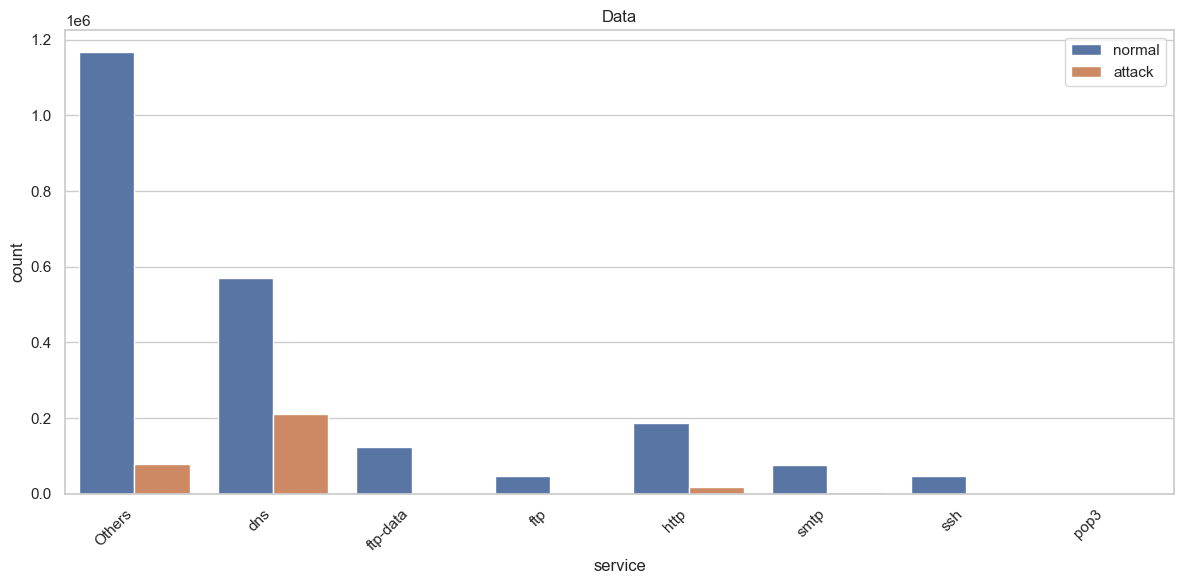

In [68]:
col_countplot('service', df_clean, ['Others', 'dns', 'http', 'ftp-data', 'smtp', 'ftp', 'ssh', 'pop3'])

As we have already replaced all the “-“ with “Others”, 
- For normal there are lots of “dns” and others that means most of “-” and few rare values. In attack data “dns” is present higher than any other values. There are few number of others and http also.

# State
The state and its dependent protocol, categorical feature.

In [69]:
check_cat_occurence('state')

+-----+-------+
|state|  count|
+-----+-------+
|  FIN|1478537|
|  CON| 560554|
|  INT| 490469|
|  REQ|   9043|
|  RST|    528|
|  CLO|    161|
|  ECO|     96|
|  URH|     54|
|  ACC|     43|
|  PAR|     26|
|  ECR|      8|
|  TST|      8|
|  URN|      7|
|  MAS|      7|
|   no|      7|
|  TXD|      5|
+-----+-------+



They are alot of occurence of those categories we will focus on the most occurences for analysis, we will focus on the 'FIN', 'CON', 'INT', 'REQ', 'RST', 'CLO'.

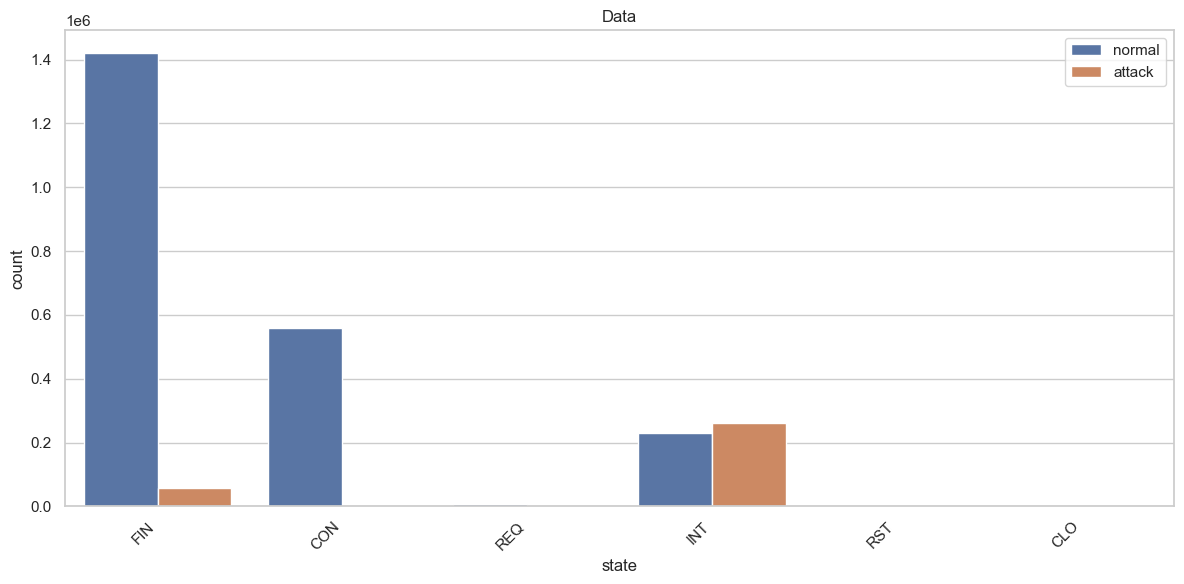

In [70]:
col_countplot('state', df_clean, ['FIN', 'CON', 'INT', 'REQ', 'RST', 'CLO'])

- For normal data "FIN" is very frequent then “cons” almost half of "FIN" and few "INT" also. In attack "INT" is higher than normal cat values. That could be really important feature to detect. There are very few "FIN".

# ct_flw_http_mthd

In [71]:
check_cat_occurence('ct_flw_http_mthd')

+----------------+-------+
|ct_flw_http_mthd|  count|
+----------------+-------+
|               0|2334442|
|               1| 188008|
|               6|   7902|
|               4|   6564|
|               3|    738|
|               2|    588|
|               5|    430|
|               9|    270|
|              14|    224|
|              12|    132|
|              30|     60|
|               8|     56|
|              16|     48|
|              36|     36|
|              10|     30|
|              25|     25|
+----------------+-------+



No. of flows that has methods such as Get and Post in http service

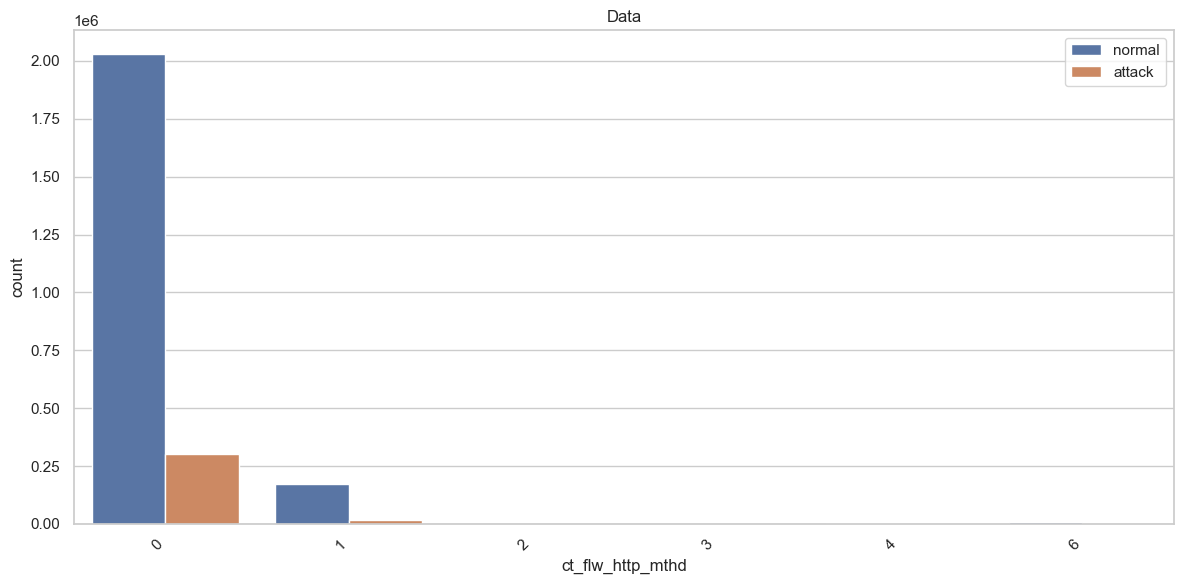

In [72]:
col_countplot('ct_flw_http_mthd', df_clean, ['0', '1', '6', '4', '3', '2'])

This is actually a numerical feature, but it has only 16 unique values.
- For normal category almost all the values are 0 and few 1.
- In attack data everything is 0 and there is very few value of 1.

# ct_state_ttl

In [73]:
check_cat_occurence('ct_state_ttl')

+------------+-------+
|ct_state_ttl|  count|
+------------+-------+
|           0|2177717|
|           2| 272001|
|           1|  81380|
|           3|   4243|
|           6|   4170|
|           4|     40|
|           5|      2|
+------------+-------+



### Use all the occurences in the ct_state_ttl column

In [74]:
# Assuming your DataFrame is named df_clean
unique_with_frequency = df_clean.groupBy('ct_state_ttl').count().collect()

# Convert the result to a list
result_list = [row['ct_state_ttl'] for row in unique_with_frequency]

print(result_list)

[1, 6, 3, 4, 2, 0, 5]


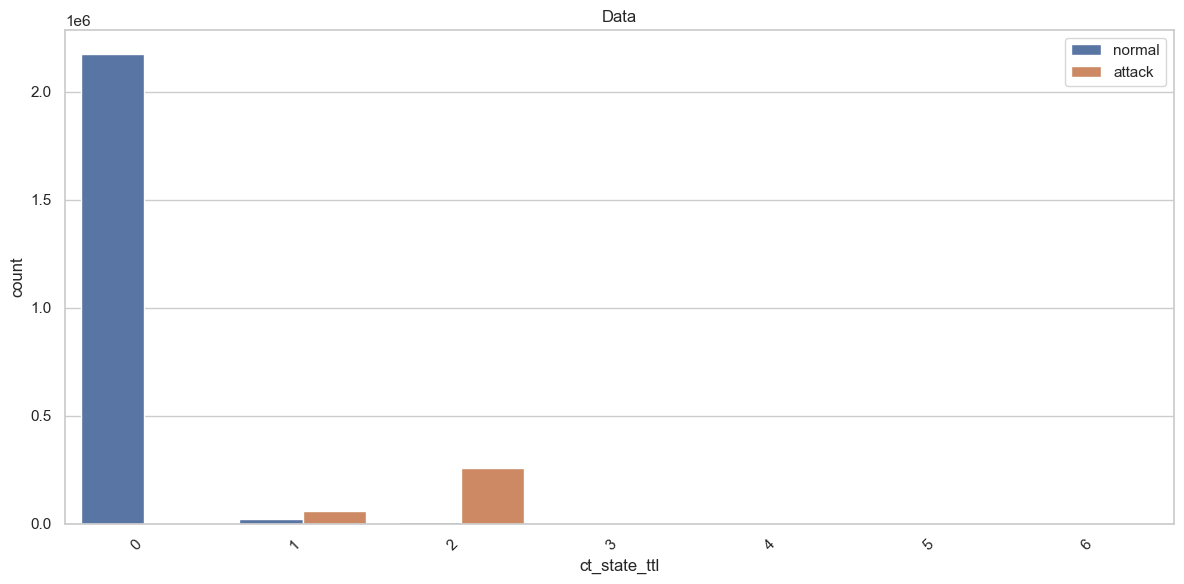

In [75]:
col_countplot('ct_state_ttl', df_clean, result_list)

Normal data has 0 as most of its values. Anomaly has most of its value 2. There are few attack with value 1 and also very little non-attack with value 1.

# Dttl and Sttl
“sttl”: Source to destination time to live, Numerical with 13 distinct values.

In [76]:
check_cat_occurence('sttl')

+----+-------+
|sttl|  count|
+----+-------+
|  31|1940538|
| 254| 331279|
|  60| 214255|
|  62|  29943|
|   0|  10447|
|   1|   4520|
|  64|   3565|
|  29|   2736|
|  32|   1602|
|  63|    285|
|  30|    225|
| 252|     84|
| 255|     74|
+----+-------+



In [77]:
unique_with_frequency = df_clean.groupBy('sttl').count().collect()
result_list = [row['sttl'] for row in unique_with_frequency]

print(result_list)

[31, 255, 1, 64, 63, 62, 29, 32, 60, 254, 30, 252, 0]


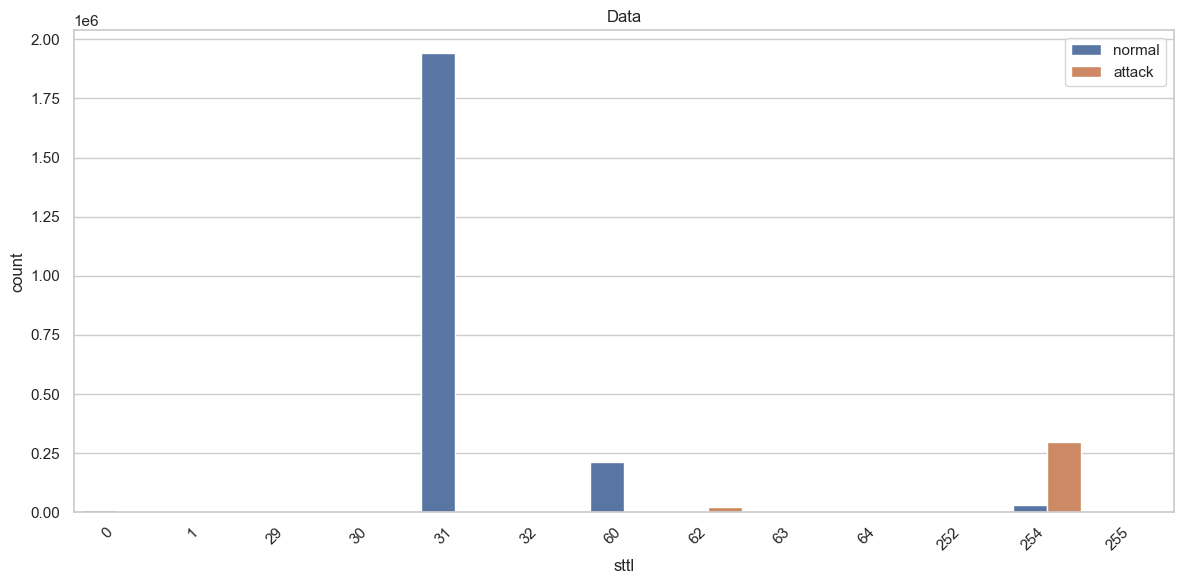

In [78]:
col_countplot('sttl', df_clean, result_list)

- Most of the values for non-attack data is 31. There are some 60 and very few 254. There lots of 254in attack data way more than non-attack data points. There are few 62 also and that is also higher than non-attack.

“dttl”: Destination to source time to live, Numerical feature with 11 unique values.

In [79]:
check_cat_occurence('dttl')

+----+-------+
|dttl|  count|
+----+-------+
|  29|1939805|
|   0| 505769|
| 252|  85210|
|  60|   4304|
|  31|   2405|
|  30|   1789|
|  32|    194|
| 254|     59|
| 253|     11|
|  62|      6|
|  64|      1|
+----+-------+



In [80]:
unique_with_frequency = df_clean.groupBy('dttl').count().collect()
result_list = [row['dttl'] for row in unique_with_frequency]

print(result_list)

[31, 29, 60, 32, 254, 30, 252, 0, 62, 253, 64]


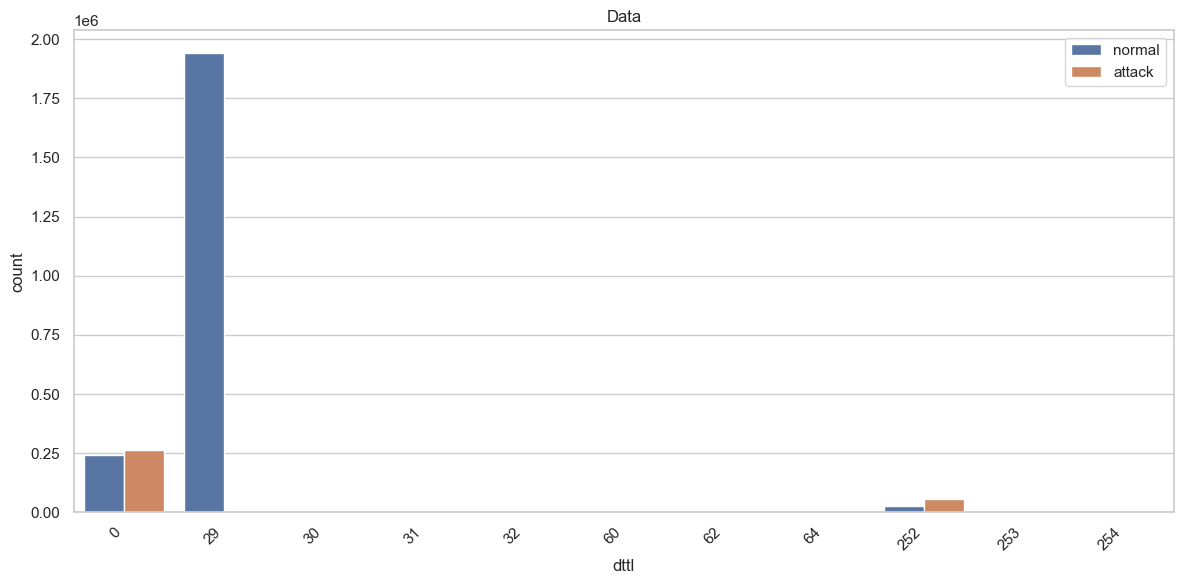

In [81]:
col_countplot('dttl', df_clean, result_list)

- Normal category data has most of its values as 29 and few of them are 0.
- Anomaly category has almost all of its value 0 considering the imbalance no of 0 for attack is more than non-attack, and there are very few 252.

# Descriptive Statistics

In [82]:
df_clean.describe().show()

+-------+-----------+-----------------+-----------+------------------+-------+-------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+----------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------+------------------+
|summary|      srcip|            sport|      dstip|            dsport|  proto|  state|               dur|           sbytes|           dbytes|       

* `summary`: This row shows the type of summary statistic calculated for each column. The possible values are `count`, `mean`, `stddev`, `min`, and `max`.
* `count`: This row shows the number of non-null values in each column.
* `mean`: This row shows the average value of each column.
* `stddev`: This row shows the standard deviation of each column, which is a measure of the spread of the data.
* `min`: This row shows the minimum value of each column.
* `max`: This row shows the maximum value of each column.

# Feature Engineering

After looking around for some useful networking feature found that we can add a new feature to our data that is Network Bytes from https://www.elastic.co/guide/en/ecs/master/ecs-network.html

Network bytes: Total bytes transferred by the network. It is sum of ‘sbytes’ (Source to destination bytes) and ‘dbytes’ (Destination to source bytes).

In [83]:
df_clean = df_clean.withColumn('network_bytes', col('sbytes') + col('dbytes'))

# Dropping columns which are not useful for the classification
# attack_cat is for multiclass classification
df_binary = df_clean.drop('srcip', 'sport', 'dstip', 'dsport', 'attack_cat')

print(df_binary.count(), len(df_binary.columns))

2539553 43


In [84]:
df_multi = df_clean.drop('srcip', 'sport', 'dstip', 'dsport')

print(df_multi.count(), len(df_multi.columns))

2539553 44


In [85]:
print([col.name for col in df_binary.schema if isinstance(col.dataType, StringType)])

['proto', 'state', 'service']


In [86]:
print([col.name for col in df_multi.schema if isinstance(col.dataType, StringType)])

['proto', 'state', 'service', 'attack_cat']


# One Hot encode the categorical variables

In [87]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

def encode_categorical_columns(df, columns):
    indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in columns]
    encoder = [OneHotEncoder(inputCol=sidx.getOutputCol(), outputCol=sidx.getOutputCol() + "_encoded") for sidx in indexers]
    
    pipeline = Pipeline(stages=indexers+encoder)
    model = pipeline.fit(df)
    encoded_df = model.transform(df)
    
    encoded_df = encoded_df.drop(*columns)
    
    return encoded_df


In [88]:
categorical_columns = ["proto", "state", "service"]
df_binary = encode_categorical_columns(df_binary, categorical_columns)

In [89]:
del categorical_columns

categorical_columns = ['proto', 'state', 'service', 'attack_cat']
df_multi = encode_categorical_columns(df_multi, categorical_columns)

In [90]:
df_binary.show(3)

+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+--------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+-----+-------------+-----------+-----------+-------------+-------------------+-------------------+---------------------+
|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit| Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|network_bytes|proto_index|state_index|service_index|proto_index_encoded|state_index_encoded|service_index_encoded|
+-------

In [91]:
df_multi.show(3)

+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+--------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+-----+-------------+-----------+-----------+-------------+----------------+-------------------+-------------------+---------------------+------------------------+
|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit| Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|network_bytes|proto_index|state_index|service_index|attack_cat_index|proto_index_

# Correlation

The correlation between each feature and the dependent variable provide elements to tackle potential undesired collinearity.

In [92]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [93]:
df_binary = df_binary.drop('attack_cat')

In [94]:
len(df_binary.columns)

46

In [95]:
from pyspark.sql.types import IntegerType, LongType, FloatType, DoubleType

numeric_types = (IntegerType, LongType, FloatType, DoubleType)  # Tuple of numeric types

non_numeric_cols = [col.name for col in df_binary.schema if not isinstance(col.dataType, numeric_types)]
numeric_cols = [col.name for col in df_binary.schema if isinstance(col.dataType, numeric_types)]

In [96]:
non_numeric_cols

['proto_index_encoded', 'state_index_encoded', 'service_index_encoded']

In [97]:
len(numeric_cols)

43

We want to analyze the `correlation` between the "Label" variable and features like 'sport','dsport','dur','sbytes','dbytes','sttl','dttl','Sload','Dload','Spkts','Dpkts','swin','dwin','ct_src_dport_ltm''ct_dst_sport_ltm','ct_dst_src_ltm',”

In [98]:
target = 'Label'
indep_cols = [x for x in df_binary[numeric_cols].columns if x not in [target]]

In [99]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import lit
from pyspark.sql.functions import abs as abs_spark
from pyspark.sql.functions import lit
from pyspark.sql.types import FloatType, StructType, StructField, StringType


def correlation_df(df, target_var, feature_cols, method):
    # Assemble features into a vector
    target_var = [target_var]
    feature_cols = indep_cols
    df_cor = df.select(target_var+feature_cols)
    assembler = VectorAssembler(inputCols=target_var+feature_cols, outputCol="features")
    df_cor = assembler.transform(df_cor)

    correlation_matrix = Correlation.corr(df_cor, "features", method=method).head()
    target_corr_list = [correlation_matrix[0][i, 0] for i in range(len(feature_cols)+1)][1:]

    # Create a list of tuples with feature names and their corresponding correlations
    correlation_data = [(feature_cols[i], float(target_corr_list[i])) for i in range(len(feature_cols))]

    # Define the schema for the DataFrame
    schema = StructType([
        StructField("feature", StringType(), nullable=False),
        StructField("correlation", FloatType(), nullable=False)
    ])

    # Create the DataFrame with the specified schema
    correlation_df = spark.createDataFrame(correlation_data, schema)
    correlation_df.show(5)
    correlation_df = correlation_df.withColumn("abs_correlation", abs_spark(correlation_df["correlation"]))

    return correlation_df

In [100]:
df_binary.show(3)

+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+--------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+-----+-------------+-----------+-----------+-------------+-------------------+-------------------+---------------------+
|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit| Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|network_bytes|proto_index|state_index|service_index|proto_index_encoded|state_index_encoded|service_index_encoded|
+-------

In [101]:
df_corr = correlation_df(
    df = df_binary[numeric_cols],
    target_var = target,
    feature_cols = indep_cols,
    method = 'pearson'
)

24/05/13 21:14:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/13 21:14:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-------+------------+
|feature| correlation|
+-------+------------+
|    dur|0.0019442843|
| sbytes| 0.010178404|
| dbytes|-0.075556874|
|   sttl|   0.9044335|
|   dttl|  0.13481387|
+-------+------------+
only showing top 5 rows



In [102]:
df_corr.show()

+-----------+------------+---------------+
|    feature| correlation|abs_correlation|
+-----------+------------+---------------+
|        dur|0.0019442843|   0.0019442843|
|     sbytes| 0.010178404|    0.010178404|
|     dbytes|-0.075556874|    0.075556874|
|       sttl|   0.9044335|      0.9044335|
|       dttl|  0.13481387|     0.13481387|
|      sloss|-0.043279067|    0.043279067|
|      dloss|-0.095869675|    0.095869675|
|      Sload|  0.19232309|     0.19232309|
|      Dload| -0.21975224|     0.21975224|
|      Spkts| -0.12089594|     0.12089594|
|      Dpkts| -0.11596305|     0.11596305|
|       swin| -0.31521404|     0.31521404|
|       dwin| -0.31402498|     0.31402498|
|      stcpb| -0.14036685|     0.14036685|
|      dtcpb| -0.13981791|     0.13981791|
|    smeansz| -0.06536615|     0.06536615|
|    dmeansz| -0.27246234|     0.27246234|
|trans_depth|-0.029053038|    0.029053038|
|res_bdy_len|-0.027343888|    0.027343888|
|       Sjit| 0.020904671|    0.020904671|
+----------

In [103]:
from pyspark.sql.functions import desc

df_corr.orderBy(desc("abs_correlation")).show()

+----------------+-----------+---------------+
|         feature|correlation|abs_correlation|
+----------------+-----------+---------------+
|            sttl|  0.9044335|      0.9044335|
|    ct_state_ttl|  0.8736964|      0.8736964|
|     state_index| 0.47992578|     0.47992578|
|  ct_dst_src_ltm|  0.4399255|      0.4399255|
|ct_dst_sport_ltm|  0.4190626|      0.4190626|
|ct_src_dport_ltm| 0.39675435|     0.39675435|
|      ct_srv_dst| 0.38651243|     0.38651243|
|      ct_srv_src| 0.38301024|     0.38301024|
|     ct_src_ ltm|   0.343249|       0.343249|
|      ct_dst_ltm| 0.33946964|     0.33946964|
|            swin|-0.31521404|     0.31521404|
|            dwin|-0.31402498|     0.31402498|
|         dmeansz|-0.27246234|     0.27246234|
|           Dload|-0.21975224|     0.21975224|
|     proto_index| 0.21721701|     0.21721701|
|           Sload| 0.19232309|     0.19232309|
|          ackdat| 0.14339833|     0.14339833|
|          tcprtt| 0.14306657|     0.14306657|
|           s

Highly correlated features indicating they may be more important predictors of the target variable. This will improve model accuracy.

# Model Building

In [104]:
df_binary = df_binary.withColumnRenamed("ct_src_ ltm", "ct_src_ltm")

In [105]:
# attack_cat_index
df_multi = df_multi.withColumnRenamed("ct_src_ ltm", "ct_src_ltm")

# Binary Classification

In [106]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols = df_binary.columns, outputCol= "features")
data_training_and_test = vector_assembler.transform(df_binary)

In [107]:
data_training_and_test.show(3)

+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+--------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+-----+-------------+-----------+-----------+-------------+-------------------+-------------------+---------------------+--------------------+
|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit| Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|network_bytes|proto_index|state_index|service_index|proto_index_encoded|state_index_encoded|service_inde

In [108]:
from pyspark.ml.feature import PCA

pca_model = PCA(k = 30,inputCol = "features", outputCol = "pca_features")
model = pca_model.fit(data_training_and_test)
data_training_and_test = model.transform(data_training_and_test)

24/05/13 21:14:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [109]:
data_training_and_test.show()

+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+---------+---------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+-----+-------------+-----------+-----------+-------------+-------------------+-------------------+---------------------+--------------------+--------------------+
|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|  Sintpkt|  Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|network_bytes|proto_index|state_index|service_index|proto_index_encoded|state

# Multiclass Classification

In [110]:
vector_assembler_multi = VectorAssembler(inputCols = df_multi.columns, outputCol= "features")
multi_data_training_and_test = vector_assembler_multi.transform(df_multi)


pca_model = PCA(k = 30,inputCol = "features", outputCol = "pca_features")
model = pca_model.fit(multi_data_training_and_test)
multi_data_training_and_test = model.transform(multi_data_training_and_test)

# Modeling fitting and tuning

We are splitting the data in to 70% train and 30% test

In [111]:
from pyspark.ml.classification import RandomForestClassifier

(training_data, test_data) = data_training_and_test.randomSplit([0.7, 0.3], 2017)
rf = RandomForestClassifier(labelCol = "Label", featuresCol = "pca_features", numTrees = 20)
rf_model = rf.fit(training_data)

24/05/13 21:15:59 WARN MemoryStore: Not enough space to cache rdd_551_6 in memory! (computed 17.6 MiB so far)
24/05/13 21:15:59 WARN BlockManager: Persisting block rdd_551_6 to disk instead.
24/05/13 21:15:59 WARN MemoryStore: Not enough space to cache rdd_551_2 in memory! (computed 41.7 MiB so far)
24/05/13 21:15:59 WARN BlockManager: Persisting block rdd_551_2 to disk instead.
24/05/13 21:15:59 WARN MemoryStore: Not enough space to cache rdd_551_7 in memory! (computed 41.7 MiB so far)
24/05/13 21:15:59 WARN BlockManager: Persisting block rdd_551_7 to disk instead.
24/05/13 21:15:59 WARN MemoryStore: Not enough space to cache rdd_551_5 in memory! (computed 26.4 MiB so far)
24/05/13 21:15:59 WARN BlockManager: Persisting block rdd_551_5 to disk instead.
24/05/13 21:15:59 WARN MemoryStore: Not enough space to cache rdd_551_4 in memory! (computed 41.7 MiB so far)
24/05/13 21:15:59 WARN BlockManager: Persisting block rdd_551_4 to disk instead.
24/05/13 21:16:00 WARN MemoryStore: Not enoug

In [112]:
rf_model.summary

In [113]:
acc = rf_model.summary.accuracy
#Area under ROC
auc = rf_model.summary.areaUnderROC
#Precision on both classes
precision = rf_model.summary.precisionByLabel
#Recall on both classes
recall = rf_model.summary.recallByLabel


print(f"Binary Classification Accuracy: {acc}")
print(f"Binary Classification Area Under ROC: {auc}")
print(f"Binary Classification Precision: {precision}")
print(f"Binary Classification Recall: {recall}")

Binary Classification Accuracy: 0.9876972049130137
Binary Classification Area Under ROC: 0.9987657396602588
Binary Classification Precision: [0.9986814524749326, 0.9182208700240757]
Binary Classification Recall: [0.9872190701755968, 0.9909990478478692]


In [114]:
predictions = rf_model.transform(test_data)

In [115]:
predictions.select("Label", "probability", "prediction").show()

+-----+--------------------+----------+
|Label|         probability|prediction|
+-----+--------------------+----------+
|    0|[0.20892904698737...|       1.0|
|    0|[0.20892904698737...|       1.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.99617462932464...|       0.0|
|    0|[0.98973071412445...|       0.0|
|    0|[0.98973071412445...|       0.0|
|    0|[0.98973071412445...|       0.0|
|    0|[0.98973071412445...|       0.0|
|    0|[0.98973071412445...|       0.0|
|    0|[0.98973071412445...|       0.0|
+-----+--------------------+----------+
only showing top 20 rows



In [116]:
(multi_training_data, multi_test_data) = multi_data_training_and_test.randomSplit([0.7, 0.3], 2017)
rf_multi = RandomForestClassifier(labelCol = "attack_cat_index", featuresCol = "pca_features", numTrees = 20)
rf_model_multi = rf_multi.fit(multi_training_data)

24/05/13 21:17:09 WARN MemoryStore: Not enough space to cache rdd_621_7 in memory! (computed 41.7 MiB so far)
24/05/13 21:17:09 WARN BlockManager: Persisting block rdd_621_7 to disk instead.
24/05/13 21:17:09 WARN MemoryStore: Not enough space to cache rdd_621_4 in memory! (computed 17.6 MiB so far)
24/05/13 21:17:09 WARN BlockManager: Persisting block rdd_621_4 to disk instead.
24/05/13 21:17:09 WARN MemoryStore: Not enough space to cache rdd_621_6 in memory! (computed 17.6 MiB so far)
24/05/13 21:17:09 WARN BlockManager: Persisting block rdd_621_6 to disk instead.
24/05/13 21:17:09 WARN MemoryStore: Not enough space to cache rdd_621_3 in memory! (computed 41.7 MiB so far)
24/05/13 21:17:09 WARN BlockManager: Persisting block rdd_621_3 to disk instead.
24/05/13 21:17:09 WARN MemoryStore: Not enough space to cache rdd_621_2 in memory! (computed 41.7 MiB so far)
24/05/13 21:17:09 WARN BlockManager: Persisting block rdd_621_2 to disk instead.
24/05/13 21:17:11 WARN MemoryStore: Not enoug

In [117]:
acc = rf_model_multi.summary.accuracy

#Precision on both classes
precision = rf_model_multi.summary.precisionByLabel
#Recall on both classes
recall = rf_model_multi.summary.recallByLabel


print(f"Multiclass Classification Accuracy: {acc}")
print(f"Multiclass Classification Precision: {precision}")
print(f"Multiclass Classification Recall: {recall}")

Multiclass Classification Accuracy: 0.96871060404135
Multiclass Classification Precision: [0.980730110073847, 0.9533715692945789, 0.5943654948890551, 0.0, 0.3952576549663928, 0.9563789868667918, 0.0, 0.0, 0.0, 0.0]
Multiclass Classification Recall: [0.9977037236530638, 0.9753752718400255, 0.6900366630218049, 0.0, 0.18552274121461748, 0.20761633234904797, 0.0, 0.0, 0.0, 0.0]


In [118]:
predictions = rf_model_multi.transform(multi_test_data)

In [119]:
predictions.show(3)

+---+------+------+----+----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+-----+-------------+-----------+-----------+-------------+----------------+-------------------+-------------------+---------------------+------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|Sload|Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|Sjit|Djit|Sintpkt|Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|network_bytes|proto_index|state_index|service_index|attack_cat

In [120]:
predictions.select("attack_cat_index", "probability", "prediction").show()

+----------------+--------------------+----------+
|attack_cat_index|         probability|prediction|
+----------------+--------------------+----------+
|             0.0|[0.30137177775167...|       0.0|
|             0.0|[0.30137177775167...|       0.0|
|             0.0|[0.99720790560922...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.98981515737915...|       0.0|
|             0.0|[0.99610082210542...|       0.0|
|             0.0|[0.99648122292167...|       0.0|
|             0.0|[0.9964812229